In [1]:
import functions_model_analysis as f

import sys  
sys.path.insert(0, '../AWS_Scripts')
from functions_training_pipeline import Model

In [ ]:
import pandas as pd


In [3]:
LR = f.load_object('LinearRegression')

In [5]:
LR.cv_model_list[0].coef_

array([ 0.10252786, -0.01898771, -0.03704107, -0.02498016,  0.39826941,
       -0.19585484,  0.04142589,  0.05256518,  0.04796803, -0.13268678,
       -1.28554681, -0.00686297, -0.17241545])

In [6]:
LR.columns

Index(['x', 'y', 'mw_value', 'mean_3', 'mean_9', 'sum_5', 'mw_value_yesterday',
       'mw_value_7_day_average', 'hours_of_daylight', 'elevation_data',
       'slope_data', 'aspect_data', 'distance_to_margin'],
      dtype='object')

In [12]:
LR.get_results()

,Set,RMSE,RMSE_std,R2,R2_std
0,Train,1.147618,0.005629,-29.243561,1.197960
1,Test,1.165040,0.053978,-31.263287,4.475446


In [9]:
[(a, b) for a, b in zip(LR.columns, LR.cv_model_list[0].coef_)]

[('x', 0.10252786062471916),
 ('y', -0.018987710360833854),
 ('mw_value', -0.0370410653158838),
 ('mean_3', -0.024980156018477105),
 ('mean_9', 0.3982694143113037),
 ('sum_5', -0.1958548356322259),
 ('mw_value_yesterday', 0.041425893058854524),
 ('mw_value_7_day_average', 0.052565178104781146),
 ('hours_of_daylight', 0.04796802558156488),
 ('elevation_data', -0.13268677834683026),
 ('slope_data', -1.2855468096923652),
 ('aspect_data', -0.006862968582951294),
 ('distance_to_margin', -0.1724154451290388)]

In [13]:
EN = f.load_object('ElasticNetRegression')

In [16]:
[(a, b) for a, b in zip(EN.columns, EN.cv_model_list[0].coef_)]

[('x', 0.0),
 ('y', -0.0),
 ('mw_value', 0.0),
 ('mean_3', 0.0),
 ('mean_9', 0.0),
 ('sum_5', 0.0),
 ('mw_value_yesterday', 0.0),
 ('mw_value_7_day_average', 0.0),
 ('hours_of_daylight', 0.0),
 ('elevation_data', -0.0),
 ('slope_data', -0.0),
 ('aspect_data', -0.0),
 ('distance_to_margin', -0.0)]

In [24]:
EN.cv_model_list[0].get_params()

{'alpha': 0.5,
 'copy_X': True,
 'fit_intercept': True,
 'l1_ratio': 0.1,
 'max_iter': 1000,
 'positive': False,
 'precompute': False,
 'random_state': None,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}

In [23]:
EN.cv_model_list[0]

[{'alpha': 0.5, 'l1_ratio': 0.1},
 {'alpha': 0.5, 'l1_ratio': 0.3},
 {'alpha': 0.5, 'l1_ratio': 0.5},
 {'alpha': 0.5, 'l1_ratio': 0.7},
 {'alpha': 0.5, 'l1_ratio': 0.9},
 {'alpha': 1, 'l1_ratio': 0.1},
 {'alpha': 1, 'l1_ratio': 0.3},
 {'alpha': 1, 'l1_ratio': 0.5},
 {'alpha': 1, 'l1_ratio': 0.7},
 {'alpha': 1, 'l1_ratio': 0.9},
 {'alpha': 2, 'l1_ratio': 0.1},
 {'alpha': 2, 'l1_ratio': 0.3},
 {'alpha': 2, 'l1_ratio': 0.5},
 {'alpha': 2, 'l1_ratio': 0.7},
 {'alpha': 2, 'l1_ratio': 0.9},
 {'alpha': 5, 'l1_ratio': 0.1},
 {'alpha': 5, 'l1_ratio': 0.3},
 {'alpha': 5, 'l1_ratio': 0.5},
 {'alpha': 5, 'l1_ratio': 0.7},
 {'alpha': 5, 'l1_ratio': 0.9},
 {'alpha': 10, 'l1_ratio': 0.1},
 {'alpha': 10, 'l1_ratio': 0.3},
 {'alpha': 10, 'l1_ratio': 0.5},
 {'alpha': 10, 'l1_ratio': 0.7},
 {'alpha': 10, 'l1_ratio': 0.9}]

In [15]:
EN.get_results()

,Set,RMSE,RMSE_std,R2,R2_std
0,Train,1.140634,0.005313,-29.061315,1.193414
1,Test,1.145251,0.054598,-31.159041,6.774506


In [29]:
# import models:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import GradientBoostingRegressor

import numpy as np

In [44]:
def feature_importance_dict(model, columns):
    """
    Function to plot feature importance.
    """
    # columns = model.columns
    # model = model.cv_model_list[0]

    if isinstance(model, DecisionTreeRegressor):
        feature_importance = model.feature_importances_
    elif isinstance(model, RandomForestRegressor):
        feature_importance = model.feature_importances_
    elif isinstance(model, GradientBoostingRegressor):
        feature_importance = model.feature_importances_
    elif isinstance(model, LinearRegression):
        feature_importance = model.coef_
    elif isinstance(model, Ridge):
        feature_importance = np.abs(model.coef_)
    elif isinstance(model, Lasso):
        feature_importance = np.abs(model.coef_)
    elif isinstance(model, ElasticNet):
        feature_importance = np.abs(model.coef_)
    else:
        print("model not supported")
        assert False

    feature_importance_dict = dict(zip(columns, feature_importance))

    return feature_importance_dict



In [67]:
def plot_feature_importance(model):
    """ Plot mean feature importance over 5 cv models with std.
    """
    feature_importance_df = []
    for mod in model.cv_model_list:
        feature_importance = feature_importance_dict(mod, model.columns)
        if len(feature_importance_df) == 0:
            feature_importance_df = pd.DataFrame(feature_importance, index=[0])
        else:
            feature_importance_df = feature_importance_df.append(feature_importance, ignore_index=True)
    
    # plot feature mean feature importance as bar plot with std: 
    feature_importance_df.mean().plot.bar(yerr=feature_importance_df.std(), capsize=5)
    

In [69]:
import matplotlib.pyplot as plt

In [72]:
import matplotlib.pyplot as plt
import numpy as np

def plot_feature_importance2(model):
    """ Plot mean feature importance over 5 cv models with std.
    """
    feature_importance_df = []
    for mod in model.cv_model_list:
        feature_importance = feature_importance_dict(mod, model.columns)
        if len(feature_importance_df) == 0:
            feature_importance_df = pd.DataFrame(feature_importance, index=[0])
        else:
            feature_importance_df = feature_importance_df.append(feature_importance, ignore_index=True)

    # sort features by mean importance in descending order by absolute value
    mean_importances = feature_importance_df.mean()
    sorted_indices = np.argsort(np.abs(mean_importances))[::-1]
    mean_importances = mean_importances[sorted_indices]
    feature_names = np.array(mean_importances.index)[sorted_indices]

    # assign colors to positive and negative features
    colors = ['red' if imp < 0 else 'green' for imp in mean_importances]

    # plot mean feature importance as bar plot with std
    fig, ax = plt.subplots()
    ax.bar(feature_names, mean_importances, yerr=feature_importance_df.std(), capsize=5, color=colors)
    ax.set_xlabel('Feature')
    ax.set_ylabel('Mean Importance')
    ax.set_title('Feature Importance')
    ax.tick_params(axis='x', rotation=90)

    plt.show()


In [74]:
LR.columns

Index(['x', 'y', 'mw_value', 'mean_3', 'mean_9', 'sum_5', 'mw_value_yesterday',
       'mw_value_7_day_average', 'hours_of_daylight', 'elevation_data',
       'slope_data', 'aspect_data', 'distance_to_margin'],
      dtype='object')

/tmp/ipykernel_718/3682944809.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_importance_df = feature_importance_df.append(feature_importance, ignore_index=True)
/tmp/ipykernel_718/3682944809.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_importance_df = feature_importance_df.append(feature_importance, ignore_index=True)
/tmp/ipykernel_718/3682944809.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_importance_df = feature_importance_df.append(feature_importance, ignore_index=True)
/tmp/ipykernel_718/3682944809.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_importance_df = feature_impo

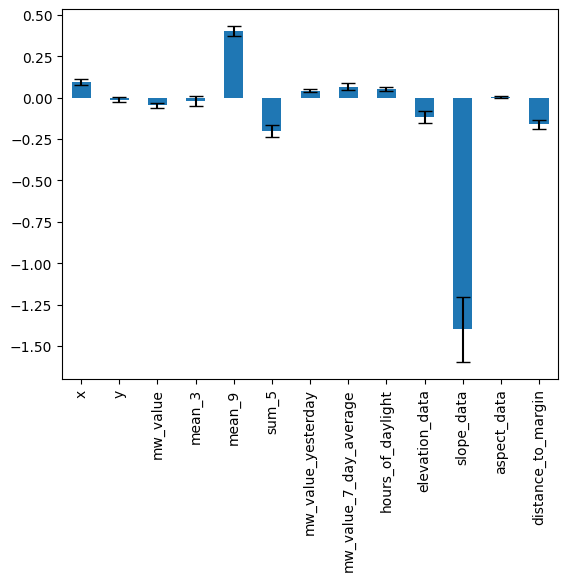

In [68]:
plot_feature_importance(LR)

/tmp/ipykernel_718/3850088050.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_importance_df = feature_importance_df.append(feature_importance, ignore_index=True)
/tmp/ipykernel_718/3850088050.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_importance_df = feature_importance_df.append(feature_importance, ignore_index=True)
/tmp/ipykernel_718/3850088050.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_importance_df = feature_importance_df.append(feature_importance, ignore_index=True)
/tmp/ipykernel_718/3850088050.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_importance_df = feature_impo

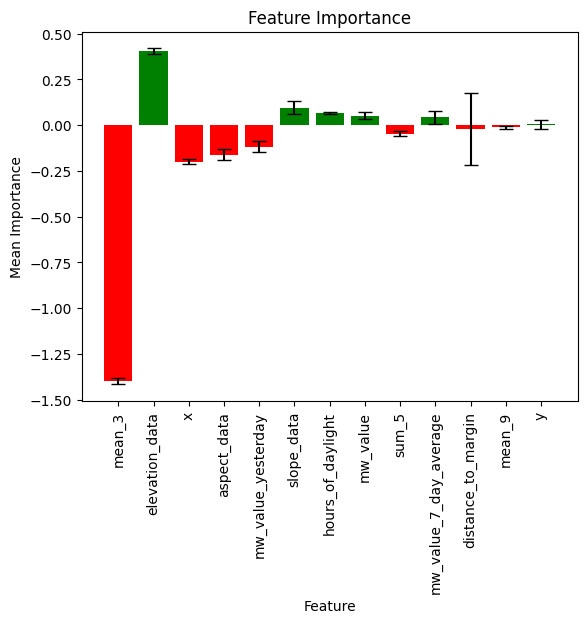

In [73]:
plot_feature_importance2(LR)